In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import sqlite3
import cpca
%matplotlib inline

In [2]:
dx_con = sqlite3.connect('dxadv.db')
doctors = pd.read_sql_query('select * from doctors;', dx_con)
doctors.head()

,id,real_id,name,gender,location,section_group,section_group_id,hospital,title
0,51845,1117,徐宏俊,1,北京西城区,皮肤科,9,首都医科大学附属北京友谊医院,主治医师
1,3953365,5479,张英,0,九江市,皮肤性病科,9,九江学院附属医院东院,副主任医师
2,2170258,6661,吴晓霞,0,咸阳市秦都区,皮肤科,9,陕西中医药大学附属医院,主任医师
3,11343870,8103,周真,0,广州市番禺区,皮肤性病科,9,广东省妇幼保健院番禺院区,主治医师
4,119604,7762,吴剑,1,沈阳市和平区,皮肤性病科,9,中国医科大学附属第一医院,主治医师


In [3]:
doctors['section_group_id'] = doctors['section_group_id'].astype('category')
doctors['gender'] = doctors['gender'].astype('category')

In [4]:
doctors['title'].unique()

array(['主治医师', '副主任医师', '主任医师', '医师'], dtype=object)

In [5]:
doctors['title_level'] = doctors['title'].map({
    '主治医师': 1,
    '副主任医师':2,
    '主任医师':3,
    '医师':0,
})

In [6]:
doctors = doctors.rename(columns={'section_group':'section'})
doctors['section_group'] = doctors['section_group_id'].map({
    9: '皮肤性病科',
    2: '儿科',
    5: '妇产科',
    8: '泌尿外科',
    40: '骨科',
    3: '内分泌科',
    60: '心血管内科',
    12: '神经内科',
    64: '消化内科',
    57: '肾脏内科',
    18: '美容整形科',
    98: '药剂科',
    6: '普通内科',
    58: '眼科',
    11: '精神心理科',
    10: '肿瘤科',
    4: '耳鼻咽喉科',
    73: '风湿免疫科',
    71: '全科',
    56: '口腔科',
    55: '呼吸内科',
    7: '普外科',
    66: '心胸外科',
    63: '神经外科',
    65: '肝胆胰腺外科',
    76: '甲状腺乳腺外科',
    70: '血液科',
    394: '影像检验科',
    68: '感染科 传染科',
    79: '疼痛科 麻醉科',
    
})

In [7]:
split_location = cpca.transform(doctors['location'], cut=False, lookahead=12)
split_location.columns = ['province', 'city', 'district', 'address']
doctors = doctors.join(split_location[['province', 'city', 'district']])

In [8]:
doctors.head()

,id,real_id,name,gender,location,section,section_group_id,hospital,title,title_level,section_group,province,city,district
0,51845,1117,徐宏俊,1,北京西城区,皮肤科,9,首都医科大学附属北京友谊医院,主治医师,1,皮肤性病科,北京市,北京市,西城区
1,3953365,5479,张英,0,九江市,皮肤性病科,9,九江学院附属医院东院,副主任医师,2,皮肤性病科,江西省,九江市,
2,2170258,6661,吴晓霞,0,咸阳市秦都区,皮肤科,9,陕西中医药大学附属医院,主任医师,3,皮肤性病科,陕西省,咸阳市,秦都区
3,11343870,8103,周真,0,广州市番禺区,皮肤性病科,9,广东省妇幼保健院番禺院区,主治医师,1,皮肤性病科,广东省,广州市,番禺区
4,119604,7762,吴剑,1,沈阳市和平区,皮肤性病科,9,中国医科大学附属第一医院,主治医师,1,皮肤性病科,辽宁省,沈阳市,和平区


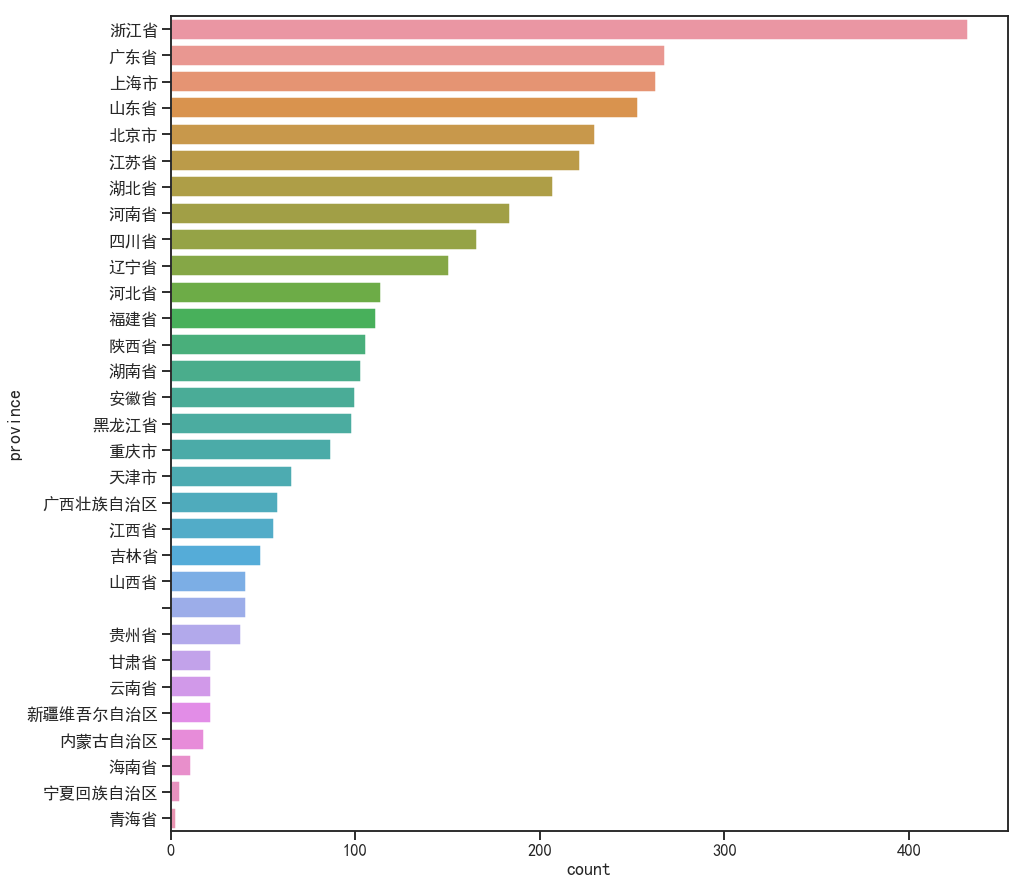

In [9]:
fig = plt.figure(figsize=(15, 15))
sns.set_style('ticks')
sns.set_context('talk')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
ax = sns.countplot(y = 'province', data=doctors, order = doctors['province'].value_counts().index)
plt.show()

In [10]:
unknown_loc = doctors[doctors['province']==''].reset_index()
unknown_loc.head()

,index,id,real_id,name,gender,location,section,section_group_id,hospital,title,title_level,section_group,province,city,district
0,33,453963,8605,袁锋,1,未知,皮肤性病科,9,武警安徽省总队医院,主治医师,1,皮肤性病科,,,
1,71,12187894,8675,曾权荣,1,未知,皮肤性病科,9,中山大学附属第三医院粤东医院,主任医师,3,皮肤性病科,,,
2,94,12253118,8668,朱晓涛,0,未知,皮肤性病科,9,佳木斯市中医院,主治医师,1,皮肤性病科,,,
3,97,2647534,8717,尹慧彬,0,未知,皮肤性病科,9,复旦大学附属华山医院,主治医师,1,皮肤性病科,,,
4,122,12499707,8732,王丽娟,-1,未知,皮肤性病科,9,唐山市妇幼保健院,主治医师,1,皮肤性病科,,,


In [11]:
unknown_loc.loc[unknown_loc['location']!='未知', 'location']

27    石河子市
31      国外
32    石河子市
40      美国
Name: location, dtype: object

In [12]:
unknown_loc[['province', 'city', 'district']] = cpca.transform(unknown_loc['hospital'])[['省', '市', '区']]
unknown_province = unknown_loc.loc[~unknown_loc[['province', 'city']].all(axis=1), :]
unknown_province

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\William\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\William\AppData\Local\Temp\jieba.cache
Loading model cost 1.301 seconds.
DEBUG:jieba:Loading model cost 1.301 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


,index,id,real_id,name,gender,location,section,section_group_id,hospital,title,title_level,section_group,province,city,district
0,33,453963,8605,袁锋,1,未知,皮肤性病科,9,武警安徽省总队医院,主治医师,1,皮肤性病科,安徽省,,
1,71,12187894,8675,曾权荣,1,未知,皮肤性病科,9,中山大学附属第三医院粤东医院,主任医师,3,皮肤性病科,,,
3,97,2647534,8717,尹慧彬,0,未知,皮肤性病科,9,复旦大学附属华山医院,主治医师,1,皮肤性病科,,,
5,131,12329386,8737,刘雄,1,未知,皮肤性病科,9,广西科技大学第一附属医院,副主任医师,2,皮肤性病科,广西壮族自治区,,
11,288,11303879,8692,葛杰,0,未知,皮肤性病科,9,浙江医院,主治医师,1,皮肤性病科,浙江省,,
16,681,12091296,8553,陈鸽子,0,未知,妇产科,5,郑州大学第一附属医院,主治医师,1,妇产科,,,
20,853,12107262,8426,卢玉霞,-1,未知,妇产科,5,中国人民解放军第一五二医院,副主任医师,2,妇产科,,,
21,862,1499487,4658,仲子星,1,未知,产科,5,浙江省人民医院,主治医师,1,妇产科,浙江省,,
22,958,28347,8331,张海萌,0,未知,妇产科,5,新疆人民医院,主任医师,3,妇产科,新疆维吾尔自治区,,
23,1048,12118766,8550,华静,-1,未知,产科,5,厦门大学附属成功医院,主治医师,1,妇产科,,,


In [13]:
def set_loc(loc, index):
    unknown_province.loc[index, 'location'] = loc

set_loc('合肥市', 0)
set_loc('广州市', 1)
set_loc('上海市', 3)
set_loc('柳州市', 5)
set_loc('杭州市', 11)
set_loc('郑州市', 16)
set_loc('平顶山市', 20)
set_loc('杭州市', 21)
set_loc('乌鲁木齐市', 22)
set_loc('厦门', 23)
set_loc('新疆石河子市', 27)
set_loc('美国', 31)
set_loc('新疆石河子市', 32)
set_loc('深圳', 36)
set_loc('深圳', 38)
set_loc('云南大理', 35)
set_loc('长沙', 39)

unknown_province[['province', 'city', 'district']] = cpca.transform(unknown_province['location'], cut=False)[['省', '市', '区']].values
unknown_province.loc[26, 'province']='未知'
unknown_province.loc[31, 'province'] = '美国'
unknown_province.loc[40, 'province'] = '美国'

C:\Users\William\Anaconda3\envs\MedicAnalysis\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\William\Anaconda3\envs\MedicAnalysis\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
unknown_loc.loc[unknown_province.index, :] = unknown_province
unknown_loc[unknown_loc['province']=='']

,index,id,real_id,name,gender,location,section,section_group_id,hospital,title,title_level,section_group,province,city,district


In [15]:
unknown_loc = unknown_loc.set_index('index')
doctors.loc[unknown_loc.index, :] = unknown_loc

In [16]:
doctors[doctors['province']==''].shape[0]

0

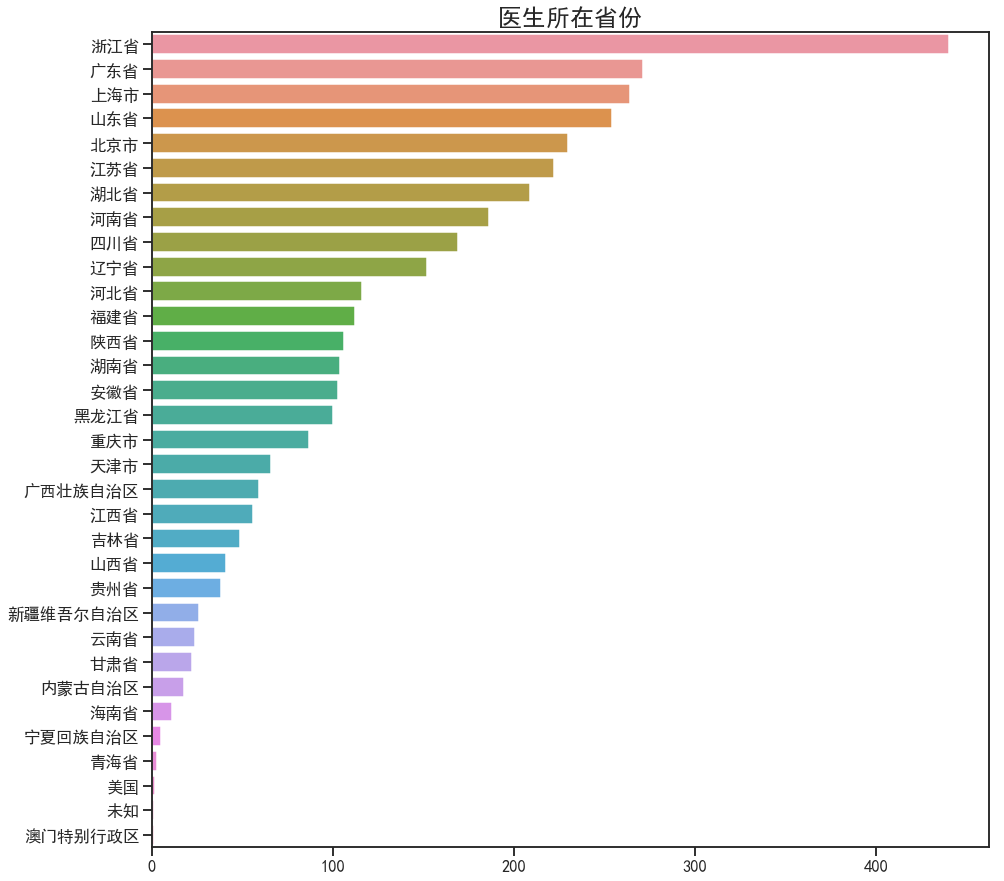

In [17]:
fig = plt.figure(figsize=(15, 15))
ax = sns.countplot(y = 'province', data=doctors, order = doctors['province'].value_counts().index)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('医生所在省份', fontsize=24)
plt.show()

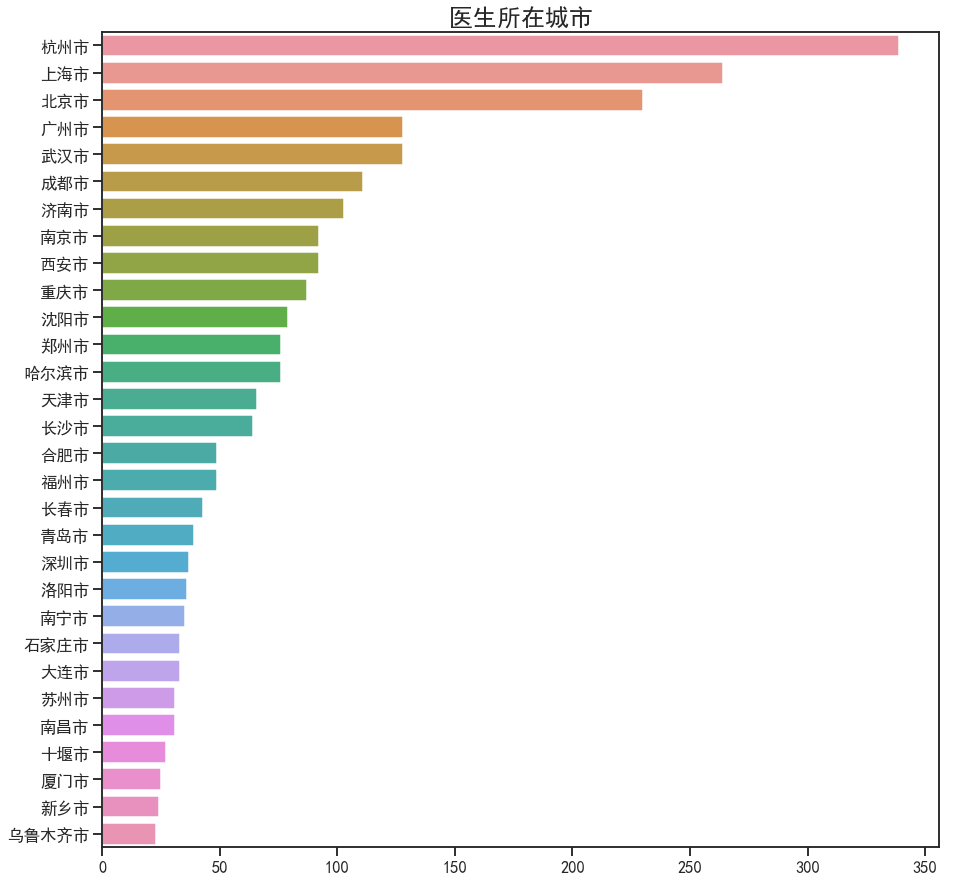

In [18]:
ncity = doctors.loc[doctors['city'].isin(doctors['city'].value_counts().index[:30]), :]
fig = plt.figure(figsize=(15, 15))
ax = sns.countplot(y = 'city', data=ncity, order = ncity['city'].value_counts().index)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
# ax.set_xticklabels(ax.get_xticks().astype(int),fontsize=16)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.title('医生所在城市', fontsize=24)
plt.show()

([<matplotlib.patches.Wedge at 0x209fa922ef0>,
 [Text(-0.2134644835440694, 1.0790889278763192, '女'),
  Text(-0.016075048344078458, -1.0998825359195117, '男'),
  Text(1.0758541843449032, -0.22921119961198072, '未知')],
 [Text(-0.11643517284221966, 0.5885939606598104, '56.2%'),
  Text(-0.008768208187679158, -0.5999359286833699, '37.1%'),
  Text(0.5868295550972199, -0.125024290697444, '6.7%')])

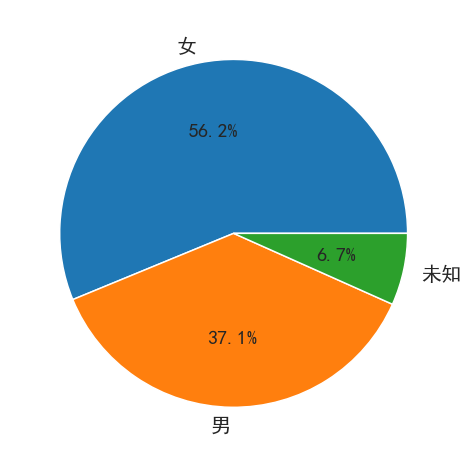

In [19]:
gender = doctors['gender'].map({0:'男', 1:'女', -1:'未知'})
ngender = gender.value_counts()
plt.figure(figsize=(8,8))
plt.pie(ngender.values, labels=ngender.index, autopct='%1.1f%%', textprops={'fontsize': 20})

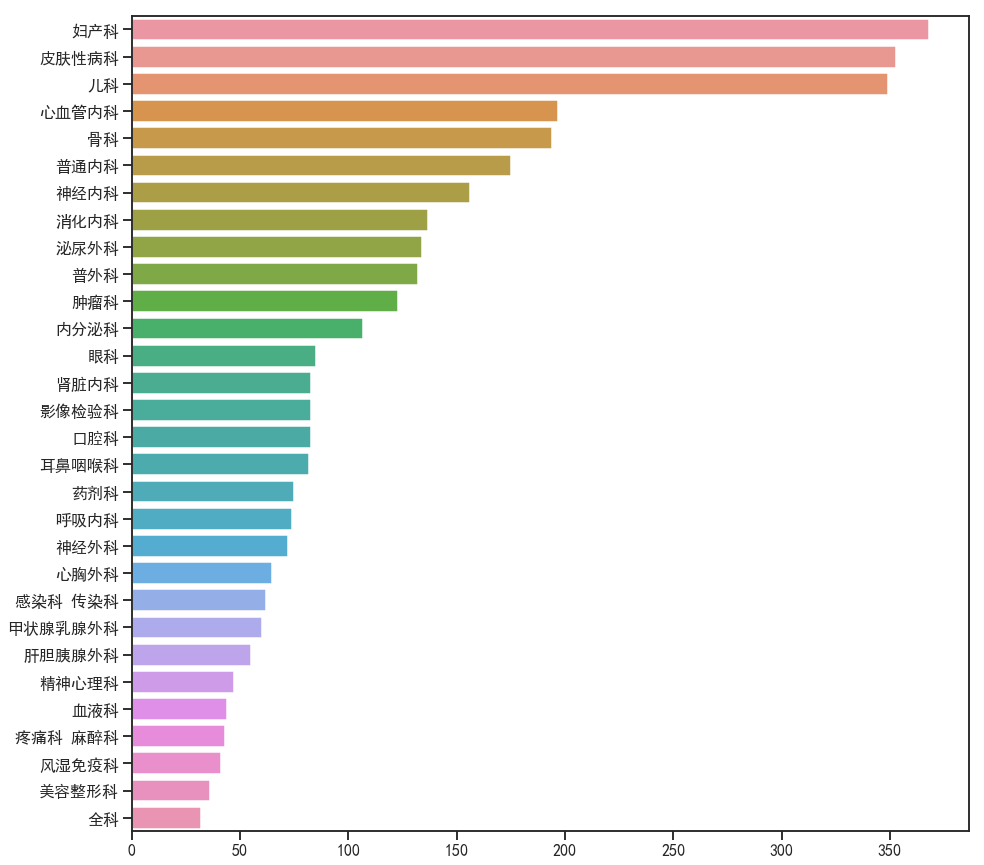

In [20]:
fig = plt.figure(figsize=(15,15))
ax = sns.countplot(y='section_group', data=doctors, order=doctors['section_group'].value_counts().index)
ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

In [34]:
plt.close()
del doctors

In [22]:
dialogs_iter = pd.read_sql('select * from dialogs_unique;', dx_con, chunksize=1000)

In [ ]:
from pkuseg import pkuseg
from tqdm import tqdm
seg = pkuseg(model_name='medicine')
tqdm.pandas(desc='dialogs progress')


def chunk_preprocess(chunk, segger):
    processed_df = chunk.copy()
    processed_df['date'] = pd.to_datetime(processed_df['date'])
    
    columns_to_seg = chunk.columns.drop(['index','id', 'date', 'doctor_id'])
    processed_df[columns_to_seg] = chunk[columns_to_seg].applymap(segger.cut)
    return processed_df

dialogs_seg = []
for dialogs in tqdm(dialogs_iter):
    dialogs_seg.append(chunk_preprocess(dialogs, seg))
dialogs_seg = pd.concat(dialogs_seg)


0it [00:00, ?it/s]
1it [00:34, 34.45s/it]
2it [01:12, 35.39s/it]
3it [01:46, 34.98s/it]
4it [02:26, 36.77s/it]
5it [02:59, 35.45s/it]
6it [03:34, 35.24s/it]
7it [04:05, 34.17s/it]

In [ ]:
dialogs_seg.to_pickle('dialogs_seg.pickle')